## Avant Garde Composer

Code to generate random 15-second orchestral compositions

In [1]:
import soundfile as sf
import tensorflow as tf
import numpy as np
    
class Song(tf.Module):
    def __init__(self, sample_bank, length_in_beats, bpm, sr):
        self.soundbank_ref = sample_bank.soundbank_ref
        self.instruments = sample_bank.instruments
        self.num_inst_samples = len(sample_bank.soundbank)
        self.length_in_beats = length_in_beats
        self.bpm = bpm
        self.sr = sr
        N = self.sr * self.length_in_beats * 60 // self.bpm
        samples_per_beat = (self.sr * 60) // self.bpm
        #padded_samples = tf.TensorArray(dtype=tf.float32, size=len(sample_bank.soundbank), element_shape=tf.TensorShape([N,]))
        padded_samples = []
        for i in range(len(sample_bank.soundbank)):
            sample = sf.read(sample_bank.soundbank[i])[0][:N,0]
            padded_sample = np.zeros(samples_per_beat * self.length_in_beats)
            padded_sample[:sample.shape[0]] = sample
            #padded_samples = padded_samples.write(i, tf.Tensor(padded_sample, dtype=tf.float32))
            padded_samples.append(padded_sample)
        #self.padded_samples = padded_samples.stack()
        self.padded_samples = tf.constant(padded_samples, dtype=tf.float32)
        self.output = tf.Variable(tf.zeros([N,], dtype=tf.float32))
        self.notes = tf.Variable(tf.zeros([self.length_in_beats, self.num_inst_samples], dtype=tf.int8))
        self.notes_float = tf.Variable(tf.zeros([self.length_in_beats * self.num_inst_samples,], dtype=tf.float32))
        self.zero()

    def zero(self):
        self.notes = self.notes.assign(tf.zeros([self.length_in_beats, self.num_inst_samples], dtype=tf.int8))
        samples_per_beat = (self.sr * 60) // self.bpm
        N = samples_per_beat * self.length_in_beats
        self.output.assign(tf.zeros([N,], dtype=tf.float32))
        
    def generate(self, instruments=None):
        if instruments is None:
            instruments = self.instruments
        length = 3 * self.length_in_beats // 4
        lst = [k for k in range(self.num_inst_samples) if self.soundbank_ref[k][0] in instruments]
        for i in range(length):
            make_note = np.random.choice([0 for i in range(9)] + [1])
            if make_note:
                j = np.random.choice(lst)
                intensity = 127 #np.random.randint(1,127)
                self.add(i, j, intensity)
    
    def compile(self):
        self.notes_float.assign(tf.reshape(tf.cast(self.notes, dtype=tf.float32) / 128.0, [self.length_in_beats * self.num_inst_samples,]))
        #self.__call__(self.notes_float, self.padded_samples)
        
    @tf.function                
    def __call__(self, notes_float, padded_samples):
        samples_per_beat = (self.sr * 60) // self.bpm
        N = samples_per_beat * self.length_in_beats
        self.zero()
        for i in range(self.length_in_beats):
            for j in range(self.num_inst_samples):
                self.output.assign_add(notes_float[i,j] * tf.roll(padded_samples[j], shift=i*samples_per_beat, axis=0))
        return None
    
    def add(self, i, j, intensity):
        # change from += to account for multiple generation
        samples_per_beat = (self.sr * 60) // self.bpm
        old_intensity = self.notes[i,j]
        new_intensity = tf.cast(intensity, dtype=tf.int8)
        float_intensity_difference = tf.cast((new_intensity - old_intensity), dtype=tf.float32) / 128.0
        self.output.assign_add(float_intensity_difference * tf.roll(self.padded_samples[j], shift=i*samples_per_beat, axis=0))
        self.notes[i,j].assign(intensity)
        
    def transform(self, matrix):
        for i in range(self.notes.shape[0]):
            self.notes[i] = tf.matmul(matrix, self.notes[i])

            
from os import listdir, getcwd, rename, remove
from os.path import isfile, join

class SampleBank(tf.Module):
    def __init__(self, name=None):
        super(SampleBank, self).__init__(name=name)
        path = join(getcwd(), 'preprocessed_samples')
        files = [f for f in listdir(path) if isfile(join(path, f)) and f[0] != '.']
        samples = []
        for f in files:
            sample = {'instrument' : '_'.join(f.split('_')[:-1]),
                      'midi_number' : int(f.split('_')[-1][:-4]),
                      'filename' : join(path, f)}
            samples.append(sample)
        samples = sorted(samples, key=lambda x: (x['instrument'], x['midi_number']))
    
        instrument_names = set([s['instrument'] for s in samples])
        instruments = {}
        for inst in instrument_names:
            samples_for_inst = {s['midi_number'] : s['filename'] for s in samples if s['instrument'] == inst}
            instruments[inst] = {'samples' : samples_for_inst,
                                 'min_note' : min(samples_for_inst.keys()),
                                 'max_note' : max(samples_for_inst.keys())}
        
        restricted_instruments = ['Marimba_cord_ff']
        soundfont = {}
        soundbank_ref = []
        k = 0
        for inst in restricted_instruments:
            print(inst, ' --- notes ',instruments[inst]['min_note'], ' through ', instruments[inst]['max_note'])
            soundfont[inst] = {}
            for i in range(128):
                if instruments[inst]['min_note'] <= i <= instruments[inst]['max_note']:
                    soundfont[inst][i] = (k, instruments[inst]['samples'][i])
                    soundbank_ref.append((inst, i))
                    k += 1
                else:
                    soundfont[inst][i] = None
        soundbank = [soundfont[x[0]][x[1]][1] for x in soundbank_ref]
        self.soundbank = soundbank
        self.soundbank_ref = soundbank_ref
        self.instruments = restricted_instruments

In [2]:
import tensorflow as tf

class Generate_Batch():
    def __init__(self, batch_size, length_in_beats, sample_rate, bpm):
        self.song = Song(SampleBank(), length_in_beats, bpm, sample_rate)
        self.batch_size = batch_size
        self.num_inst_samples = self.song.num_inst_samples
        self.length_in_beats = length_in_beats
        self.bpm = bpm
        self.sr = sample_rate
        self.N = self.sr * self.length_in_beats * 60 // self.bpm
        self.samples_per_beat = (self.sr * 60) // self.bpm
        self.batch_audio = tf.Variable(tf.zeros([self.batch_size, self.length_in_beats, self.samples_per_beat*5], dtype=tf.float32))
        self.batch_piano_roll = tf.Variable(tf.zeros([self.batch_size, self.length_in_beats, self.num_inst_samples], dtype=tf.float32))
    
    #@tf.function
    def __call__(self):
        #batch_audio = tf.TensorArray(dtype=tf.float32, size=self.batch_size, element_shape=tf.TensorShape([self.N,]))
        #batch_piano_roll = tf.TensorArray(dtype=tf.float32, size=self.batch_size, element_shape=tf.TensorShape([ self.length_in_beats * self.num_inst_samples,]))
        for i in range(self.batch_size):
            self.song.zero()
            for j in range(np.random.choice([3,4,5,6,7,8,9,10,11,12])):
                self.song.generate()
            self.song.compile()
            for j in range(self.song.length_in_beats - 4):
                self.batch_audio[i,j].assign(
                    self.song.output[j*self.samples_per_beat:(j+5)*self.samples_per_beat]
                )
                self.batch_piano_roll[i,j].assign(
                    tf.reshape(self.song.notes_float, [self.song.length_in_beats, self.song.num_inst_samples])[j]
                )
        #return batch_audio.stack(), batch_piano_roll.stack()
        return self.batch_audio, self.batch_piano_roll    

In [3]:
batch_size = 10
batches_per_epoch = 10

generate_batch = Generate_Batch(batch_size, 4*10, 44100, 60*10)

Marimba_cord_ff  --- notes  36  through  96


In [4]:
from IPython.display import Audio

generate_batch.song.generate()
example_composition = generate_batch.song.output.numpy()

Audio(example_composition, rate=44100, autoplay=True)

## Neural Network Layer Classes

In [5]:
import tensorflow as tf
import numpy as np

scaling=0.01

class STFTLayer(tf.Module):
    def __init__(self, input_features, frame_length, frame_step, name=None):
        super(STFTLayer, self).__init__(name=name)
        self.input_features = input_features
        self.frame_length = frame_length
        self.frame_step = frame_step
        #i = 0
        #while frame_length + i*frame_step < input_features:
        #    i +=1
        #self.num_frames = i+1
        self.num_frames = -(-input_features // frame_step)
        i = 0
        while (2 ** i) < frame_length:
            i += 1
        self.fft_length = 2 ** i
        self.fft_unique_bins = self.fft_length // 2 + 1
        self.output_features = 2 * self.fft_unique_bins * self.num_frames
        print(f'STFT Layer. Input Features: {self.input_features} Output Features: {self.output_features}')
        print(f'FFT Unique Bins: {self.fft_unique_bins} Num Frames: {self.num_frames}')
        
    def reset(self):
        pass
        
        
    @tf.function
    def __call__(self, x): 
        stft_shape = x.shape
        stft = tf.signal.stft(x,
                              self.frame_length,
                              self.frame_step,
                              fft_length=self.fft_length,
                              window_fn=tf.signal.hann_window,
                              pad_end=True,
                              name=None)
        return tf.concat(tf.unstack(tf.concat([tf.math.real(stft), tf.math.imag(stft)], axis=-2), axis=-2), axis=-1)
        #return tf.concat(tf.unstack(tf.concat([tf.math.real(stft), tf.math.imag(stft)], axis=-1), axis=-1), axis=-1)
    
class RFFTLayer(tf.Module):
    def __init__(self, input_features, name=None):
        super(RFFTLayer, self).__init__(name=name)
        self.input_features = input_features
        i = 0
        while (2 ** i) < self.input_features:
            i += 1
        self.fft_length = [2 ** i]
        self.output_features = 2 * (1 + 2 ** (i-1))
        print(f'RFFT Layer. Input Features: {self.input_features} Output Features: {self.output_features}')
        
    def reset(self):
        pass
    
    @tf.function
    def __call__(self, x):
        rfft = tf.signal.rfft(x, fft_length=self.fft_length)
        return tf.concat([tf.math.real(rfft), tf.math.imag(rfft)], axis=-1)

        return result
    
class ReluLayer(tf.Module):
    def __init__(self, input_features, output_features, scaling=None, name=None):
        super(ReluLayer, self).__init__(name=name)
        self.input_features = input_features
        self.output_features = output_features
        if scaling:
            self.scaling = tf.constant(scaling, dtype=tf.float32)
        else:
            self.scaling = tf.constant(1.0 / self.input_features, dtype=tf.float32)
        self.w = tf.Variable(tf.random.normal([self.input_features, self.output_features],
                                              dtype=tf.float32,
                                              mean=0.0,
                                              stddev=1.0), name='w')
        self.b = tf.Variable(tf.zeros([self.output_features], dtype=tf.float32), name='b')
        print(f'RELU Layer. Input Features: {self.input_features} Output Features: {self.output_features}')

        
    def reset(self):
        self.w.assign(tf.random.normal([self.input_features, self.output_features],
                                       dtype=tf.float32,
                                       mean=0.0,
                                       stddev=1.0))
        self.b.assign(tf.zeros([self.output_features], dtype=tf.float32))
    
    @tf.function
    def __call__(self, x):
        y = tf.tensordot(self.scaling * x, self.w, axes=1) + self.b
        return tf.nn.relu(y)
    

class SeluLayer(tf.Module):
    def __init__(self, input_features, output_features, scaling=None, name=None):
        super(SeluLayer, self).__init__(name=name)
        self.input_features = input_features
        self.output_features = output_features
        if scaling:
            self.scaling = tf.constant(scaling, dtype=tf.float32)
        else:
            self.scaling = tf.constant(1.0 / self.input_features, dtype=tf.float32)
        self.w = tf.Variable(tf.random.normal([self.input_features, self.output_features],
                                              dtype=tf.float32,
                                              mean=0.0,
                                              stddev=1.0), name='w')
        self.b = tf.Variable(tf.zeros([self.output_features], dtype=tf.float32), name='b')
        print(f'SELU Layer. Input Features: {self.input_features} Output Features: {self.output_features}')

        
    def reset(self):
        self.w.assign(tf.random.normal([self.input_features, self.output_features],
                                       dtype=tf.float32,
                                       mean=0.0,
                                       stddev=1.0))
        self.b.assign(tf.zeros([self.output_features], dtype=tf.float32))
    
    @tf.function
    def __call__(self, x):
        y = tf.tensordot(self.scaling * x, self.w, axes=1) + self.b
        return tf.nn.selu(y)

class SigmoidLayer(tf.Module):
    def __init__(self, input_features, output_features, scaling=None, name=None):
        self.input_features = input_features
        self.output_features = output_features
        if scaling:
            self.scaling = tf.constant(scaling, dtype=tf.float32)
        else:
            self.scaling = tf.constant(1.0 / self.input_features, dtype=tf.float32)
        super(SigmoidLayer, self).__init__(name=name)
        self.w = tf.Variable(tf.random.normal([self.input_features, self.output_features],
                                              dtype=tf.float32,
                                              mean=0.0,
                                              stddev=1.0), name='w')
        self.b = tf.Variable(tf.zeros([self.output_features], dtype=tf.float32), name='b')
        print(f'Sigmoid Layer. Input Features: {self.input_features} Output Features: {self.output_features}')

        
    def reset(self):
        self.w.assign(tf.random.normal([self.input_features, self.output_features],
                                       dtype=tf.float32,
                                       mean=0.0,
                                       stddev=1.0))
        self.b.assign(tf.zeros([self.output_features], dtype=tf.float32))
    
    
    @tf.function
    def __call__(self, x):
        y = tf.tensordot(self.scaling * x, self.w, axes=1) + self.b
        return tf.nn.sigmoid(y)
    
class DisperseLayer(tf.Module):
    def __init__(self, input_features, chunk_size, shift_percentage, name=None):
        super(DisperseLayer, self).__init__(name=name)
        self.input_features = input_features
        inverse_shift_ratio = int(round(1 / shift_percentage))
        self.num_chunks = (inverse_shift_ratio*(input_features - chunk_size) // chunk_size) + 1
        self.shift_size = chunk_size // inverse_shift_ratio
        self.chunk_size = chunk_size
        print(f'Disperse Layer. Input Features: {input_features} Chunk Size: {chunk_size} Num Chunks: {self.num_chunks}')
    
    def reset(self):
        pass
    
    @tf.function
    def __call__(self, x):
        output_array = tf.TensorArray(dtype=tf.float32, size=self.num_chunks)
        shape = x.get_shape()
        other_dims = shape.rank - 1
        for i in range(self.num_chunks):
            begin = [0 for i in range(other_dims)]+[i*self.shift_size]
            size = [-1 for i in range(other_dims)]+[self.chunk_size]
            output_array = output_array.write(i, tf.slice(x, begin, size))
        return output_array.stack()
    
class JoinLayer(tf.Module):
    def __init__(self, chunk_size, num_chunks, name=None):
        super(JoinLayer, self).__init__(name=name)
        self.chunk_size = chunk_size
        self.num_chunks = num_chunks
        self.output_features = chunk_size * num_chunks
        #print(f'Join Layer. Input Chunk Size: {chunk_size} Num Input Chunks: {num_chunks} Output Features: {self.output_features}')
        
    def reset(self):
        pass
    
    @tf.function
    def __call__(self, x):
        players = tf.unstack(x, axis=0)
        return tf.concat(players, axis=-1)
        
# In a sparse layer, the input and outputs are each divided into an equal number
# of (probably overlapping) chunks. Every neuron in input chunk j is connected to
# every neuron in output chunk j. 
class SparseLayer(tf.Module):
    def __init__(self, input_features, input_chunk_size, input_chunk_step,
                 output_features, output_chunk_size, output_chunk_step, name=None):
        super(SparseLayer, self).__init__(name=name)
        if (input_features - input_chunk_size) % input_chunk_step != 0:
            raise ValueError('input_features must be of the form input_chunk_size + k*input_chunk_step for some k')
        if (output_features - output_chunk_size) % output_chunk_step != 0:
            raise ValueError('output_features must be of the form output_chunk_size + k*output_chunk_step for some k')
        if (input_chunk_step > input_chunk_size) or (output_chunk_step > output_chunk_size):
            raise ValueError('chunk step should be no bigger than chunk size')
        num_input_chunks = 1 + ((input_features - input_chunk_size) // input_chunk_step)
        num_output_chunks = 1 + ((output_features - output_chunk_size) // output_chunk_step)
        if num_input_chunks != num_output_chunks:
            raise ValueError('number of input chunks and output chunks does not match')
        self.num_chunks = num_input_chunks
        self.input_features = input_features
        self.input_chunk_size = input_chunk_size
        self.input_chunk_step = input_chunk_step
        self.output_features = output_features
        self.output_chunk_size = output_chunk_size
        self.output_chunk_step = output_chunk_step
        self.w = tf.Variable(tf.random.normal([num_chunks, input_chunk_size, output_chunk_size], dtype=tf.float32, stddev=scaling), name='w')
        self.b = tf.Variable(tf.zeros([num_chunks, output_chunk_size], dtype=tf.float32), name='b')
        #print(f'Sparse Layer. Input Features: {input_features} Output Features: {self.output_features}')
        #print(f'Input Chunk Size: {input_chunk_size} Input Chunk Step: {input_chunk_step}')
        #print(f'Output Chunk Size: {output_chunk_size} Output Chunk Step: {output_chunk_step}')

        
    @tf.function
    def __call__(self, x):
        output_array = tf.TensorArray(dtype=tf.float32, size=self.num_chunks)
        
        input_shape = x.get_shape()
        other_dims = shape.rank - 1
        
        zeros_to_concat_shape = input_shape.as_list()
        zeros_to_concat_shape[-1] = output_features - output_chunk_size

        y = tf.zeros(output_shape, dtype=tf.float32)
        
        for i in range(self.num_chunks):
            begin = [0 for i in range(other_dims)]+[i*self.input_chunk_step]
            size = [-1 for i in range(other_dims)]+[chunk_size]
            chunk = tf.concat([tf.tensordot(tf.slice(x, begin, size), self.w[i], axes=1) + self.b[i],
                               tf.zeros(zeros_to_concat_shape, dtype=tf.float32)],
                              axis=-1)
            rolled_chunk = tf.roll(chunk, shift=i*self.output_chunk_step, axis=-1)
            output_array.write(i, rolled_chunk)
        pre_y = output_array.stack()
        y = tf.reduce_sum(pre_y, 0)
        return tf.nn.relu(y)

In [6]:
class Network(tf.Module):
    def __init__(self, name=None):
        super(Network, self).__init__(name=name)
        self.layers = []
        
                
        sample_rate = 44100                 # 44.1khz sample rate
        frame_length = sample_rate // 10    # frame size of 0.1 seconds
        num_frames = 5                      # five frames read at a time
        input_features = int(frame_length * num_frames)
    
        self.layers.append(DisperseLayer(input_features, frame_length, 1.0))
        num_chunks = num_frames
        
        self.layers.append(RFFTLayer(self.layers[-1].chunk_size))
        
        self.layers.append(ReluLayer(self.layers[-1].output_features, self.layers[-1].output_features // 16, scaling=1/100))
        self.layers.append(ReluLayer(self.layers[-1].output_features, self.layers[-1].output_features // 2, scaling=1/50))
        self.layers.append(ReluLayer(self.layers[-1].output_features, self.layers[-1].output_features // 2, scaling=1/50))
        
        
        self.layers.append(JoinLayer(self.layers[-1].output_features, num_chunks))

        self.layers.append(ReluLayer(self.layers[-1].output_features, self.layers[-1].output_features // 4, scaling=1/250))
        self.layers.append(SigmoidLayer(self.layers[-1].output_features, 61, scaling=1/100))
        
    def apply(self, data, layers):
        if len(layers) == 1:
            return layers[0](data)
        else:
            return self.apply(layers[0](data), layers[1:])

    #@tf.function
    def __call__(self, data):
        x = data
        for i, layer in enumerate(self.layers):
            x = layer(x)
        return x
        #return self.apply(data, self.layers)
        
    def reset(self):
        for layer in self.layers:
            layer.reset()

network = Network()

Disperse Layer. Input Features: 22050 Chunk Size: 4410 Num Chunks: 5
RFFT Layer. Input Features: 4410 Output Features: 8194
RELU Layer. Input Features: 8194 Output Features: 512
RELU Layer. Input Features: 512 Output Features: 256
RELU Layer. Input Features: 256 Output Features: 128
RELU Layer. Input Features: 640 Output Features: 160
Sigmoid Layer. Input Features: 160 Output Features: 61


In [7]:
def clean_output(arr):
    N = arr.shape[0]
    M = arr.shape[1]
    output = np.zeros([N, M])
    for i in range(N):
        for j in range(M):
            output[i][j] = int(max(0, min(127, round(128 * arr[i][j]))))
    return output

In [8]:
network.reset()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid value for "node": expected "ast.AST", got "<class 'NoneType'>"; to visit lists of nodes, use "visit_block" instead
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid value for "node": expected "ast.AST", got "<class 'NoneType'>"; to visit lists of nodes, use "visit_block" instead
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid value for "node": expected "ast.AST", got "<class 'NoneType'>"; to visit lists of nodes, use "visit_block" instead
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

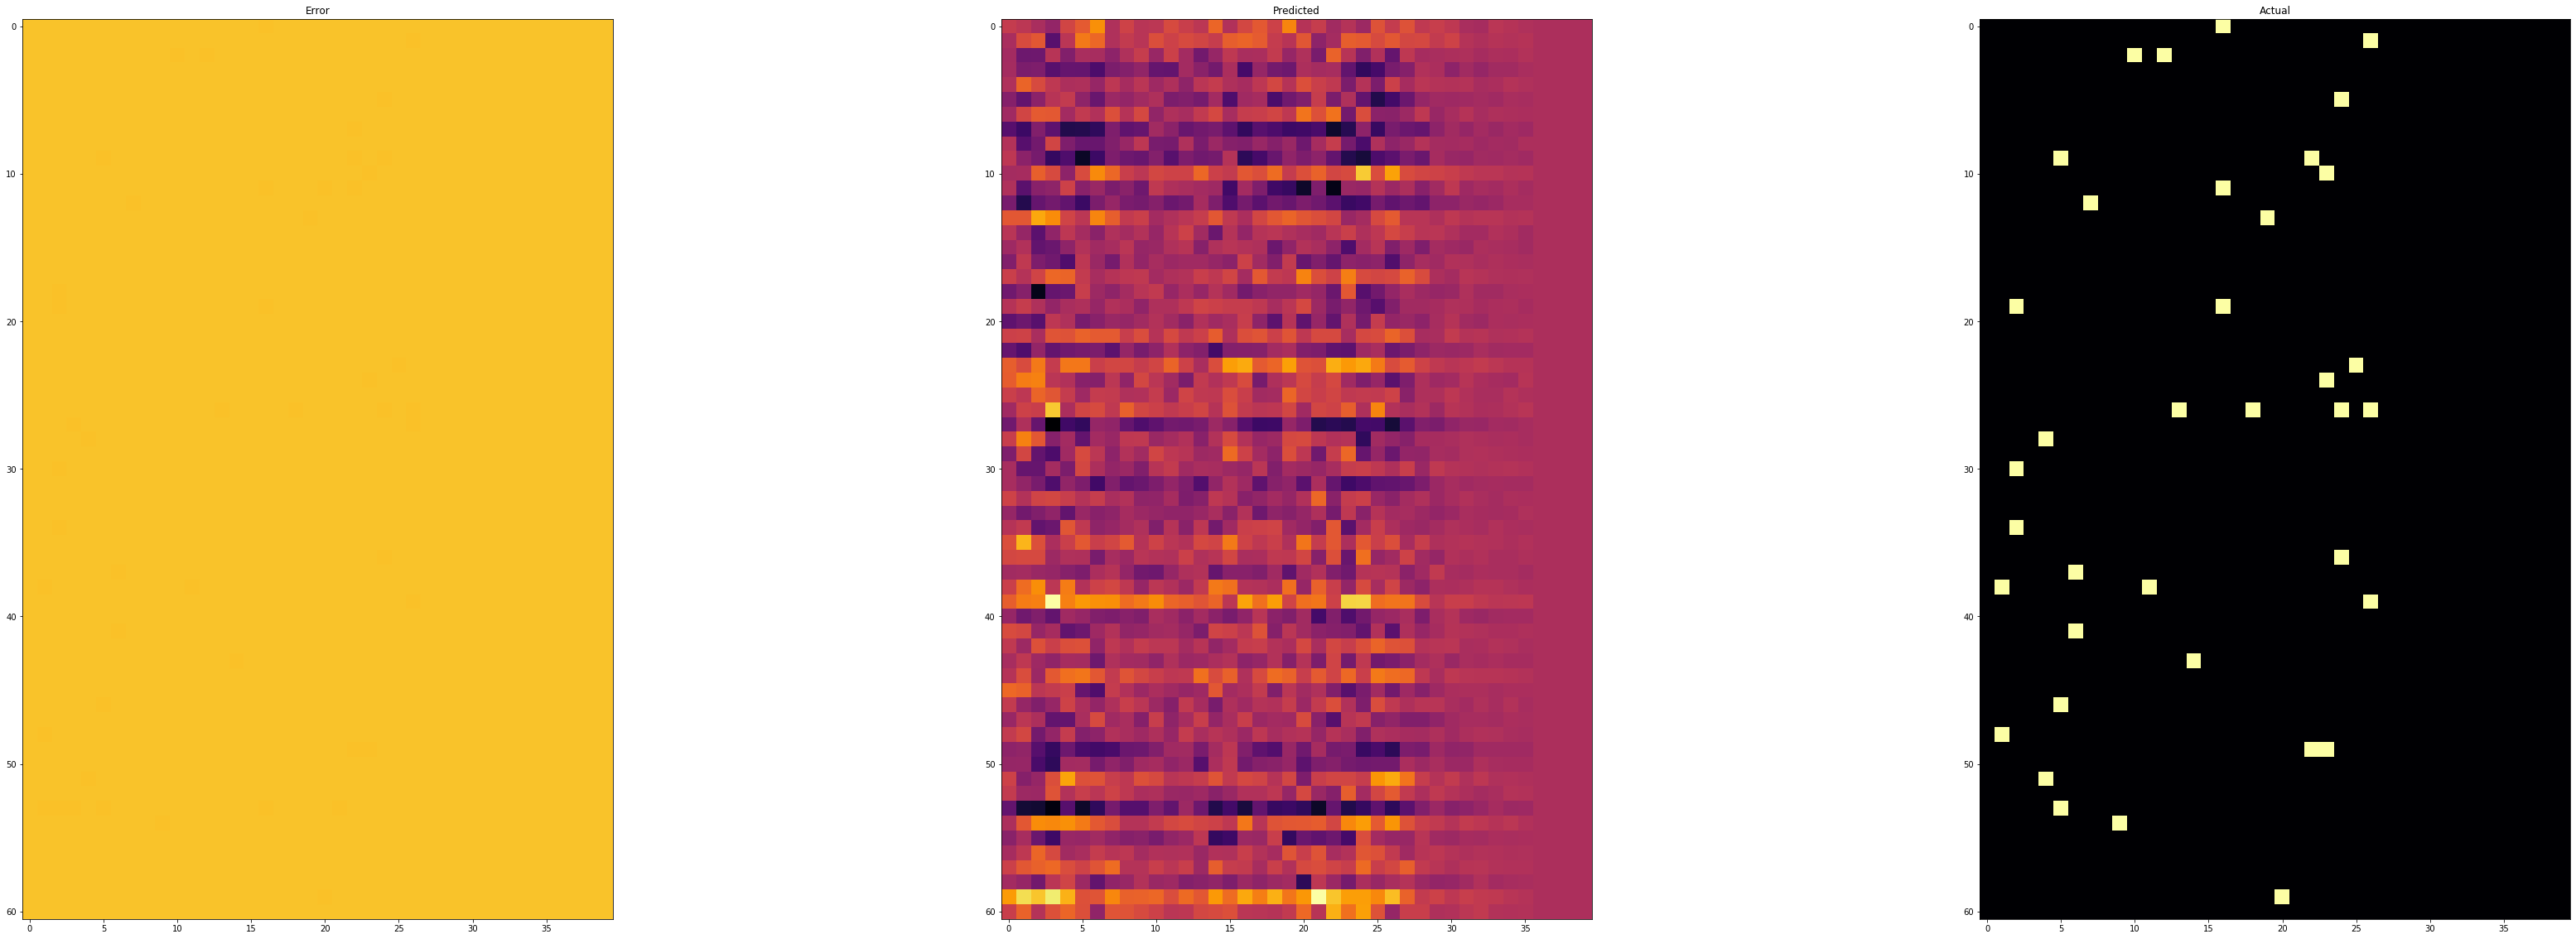

Step 0 complete.
loss 2499.26172
GLobal Norm: 316.39203
Step 1 complete.
loss 2499.05762
GLobal Norm: 314.8809
Step 2 complete.
loss 2498.99146
GLobal Norm: 314.6087
Step 3 complete.
loss 2498.94702
GLobal Norm: 314.1249
Step 4 complete.
loss 2499.29883
GLobal Norm: 316.41653
Step 5 complete.


In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, Audio
import seaborn as sns
import sys, signal

keep_going = True
def signal_handler(signal, frame):
    global keep_going
    keep_going = False
signal.signal(signal.SIGINT, signal_handler)

@tf.function
def loss(notes_actual, notes_predicted):
    note_correctness_error = 10000*tf.reduce_mean((notes_actual - notes_predicted) ** 2)
    #note_correctness_error = 1 - tf.reduce_mean(tf.reduce_mean(((1/128) + notes_actual) * ((1/128) + notes_predicted), axis=-1) / (tf.reduce_mean(((1/128) + notes_predicted) ** 2, axis=-1) ** (1/2) * tf.reduce_mean(((1/128) + notes_actual) ** 2, axis=-1) ** (1/2)))
    #energy_actual = 10*tf.reduce_mean(notes_actual ** 2, axis=-1) - (tf.reduce_mean(notes_actual, axis=-1) ** 2)
    #energy_predicted = 10*tf.reduce_mean(notes_predicted ** 2, axis=-1) - (tf.reduce_mean(notes_predicted, axis=-1) ** 2)
    #mean_energy_error = tf.reduce_mean(tf.abs(energy_actual - energy_predicted))
    #amplitude = 10*tf.minimum(tf.maximum(1.0 - tf.reduce_max(notes_predicted), 0.0), 1.0)
    loss = (note_correctness_error)# + mean_energy_error)
    #tf.print('Loss', loss, ', Amp', amplitude, ', Note', note_correctness_error, ', Energy', total_energy_error)
    tf.print('loss', loss)#, 'note_correctness_error', note_correctness_error, 'mean_energy_error', mean_energy_error)
    return loss
    

@tf.function
def grad(network, input_pcms, notes_actual):
    with tf.GradientTape() as tape:
        tape.watch(network.trainable_variables)
        notes_predicted = network(input_pcms)
        loss_value = loss(notes_actual, notes_predicted)
    return loss_value, notes_predicted, tf.clip_by_global_norm(tape.gradient(loss_value, network.trainable_variables), 1000000.0)

#@tf.function
def apply_grads(trainable_vars, grads, global_norm, learning_rate):
    if (2 ** -120) < global_norm.numpy() < 1.0:
        scaling = 1.0 / global_norm.numpy()
    else:
        scaling = 1.0  
    for i in range(len(grads)):
        trainable_vars[i].assign_sub(learning_rate * scaling * grads[i])

#optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.001) #, momentum=0.01) #, momentum=0.1, nesterov=True)
optimizer=tf.keras.optimizers.SGD(learning_rate=0.001)


num_inst_samples = 61
length_in_seconds = 4
quantization = 10
length_in_beats = length_in_seconds * quantization




#learning_rate = 0.0000001

grads = tuple(tf.Variable(tf.zeros_like(var, dtype=tf.float32)) for var in network.trainable_variables)

i = -1
while keep_going:
    i += 1
    input_pcms, notes_actual = generate_batch()

    loss_value, notes_predicted, (new_grads, global_norm) = grad(network, input_pcms, notes_actual)
    print('GLobal Norm:', global_norm.numpy())
    #if (2 ** -120) < global_norm.numpy() < 1.0:
    #    scaling = 1.0 / global_norm.numpy()
    #else:
    #    scaling = 1.0    
    for j in range(len(grads)):
        grads[j].assign_add(new_grads[j] / batches_per_epoch)

    #apply_grads(network.trainable_variables, new_grads, learning_rate, scaling)
    
    if i % 10 == 0:
        
        notes_predicted_numpy = 128 * notes_predicted[batch_size-1].numpy()
        notes_actual_numpy = 128 * notes_actual[batch_size-1].numpy()
        
        #predicted_audio = song(clean_output(notes_predicted_numpy))
        #audio = Audio(predicted_audio, rate=44100, autoplay=True)
    
        
        fig, axes = plt.subplots(1,3,figsize=(60,20))
        
        #error
        axes[0].imshow(np.log(1+np.abs(notes_actual_numpy - notes_predicted_numpy).T), aspect=(1), cmap='inferno', vmin=np.log(1), vmax=np.log(128))
        axes[0].set_title('Error')
        

        # predicted
        axes[1].imshow(np.log(1+notes_predicted_numpy.T), aspect=(1), cmap='inferno')#, vmin=np.log(1), vmax=np.log(128))
        axes[1].set_title('Predicted')
        
        #actual
        axes[2].imshow(np.log(1+notes_actual_numpy.T), aspect=(1), cmap='inferno', vmin=np.log(1), vmax=np.log(128))
        axes[2].set_title('Actual')

        #print(128*np.max(notes_predicted_numpy))
        
        #display(audio)
        display(fig)
        plt.close(fig)

    if i % 100 == 99:
        clear_output()
    
    if (i % batches_per_epoch) == (batches_per_epoch - 1):
        #apply_grads(network.trainable_variables, *tf.clip_by_global_norm(grads, 1.0), learning_rate)
        optimizer.apply_gradients(zip(grads, network.trainable_variables))
    
    
    #    clear_output()
    #    #optimizer.apply_gradients(zip(grads, network.trainable_variables))
    #    apply_grads(network.trainable_variables, grads, learning_rate)
    #    
        for j in range(len(grads)):
            grads[j].assign(tf.zeros_like(network.trainable_variables[j], dtype=tf.float32))

        
        #save = tf.train.Checkpoint()
        #save.listed = network.trainable_variables
        #save_path = save.save('./checkpoints/checkpoint4B')
        #print(save_path)
        #print(f'Epoch {i // batches_per_epoch} completed!')

    print('Step', i, 'complete.')
    #print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
    #$                                     loss_value.numpy()))


In [ ]:
save = tf.train.Checkpoint()
save.listed = network.trainable_variables

save_path = save.save('./checkpoints/checkpoint')
print(save_path)

In [ ]:
save_path='./checkpoints/checkpoint4-1'

restore = tf.train.Checkpoint()
restore.restore(save_path)
restore.listed = network.trainable_variables